**Задача:**
> Найти кратчайший замкнутый цикл *(путь)*, который проходит через каждое ребро *неориентированного* графа

***Эйлеров путь*** (эйлерова цепь) — это путь, проходящий по всем рёбрам графа и притом только по одному разу.
<br>***Эйлеров цикл*** — эйлеров путь, являющийся циклом, то есть замкнутый путь, проходящий через каждое ребро графа ровно по одному разу.

**Решение:**
<br>Если граф Эйлеров, нужно найти Эйлеров цикл.
Если такого пути не существует, сгенерируем его из данного графа:
> Найдём минимальный набор ребер графа для дублирования таким образом, чтобы полученный мультиграф действительно имел эйлерову схему.<br>
> Подмножество ребер должно иметь минимально возможный общий вес или, если вес ребра не является фактором, наименьшее число ребер.

**Алгоритм:**
1. Найти все узлы с нечетной степенью
2. Добавить ребра к графу таким образом, чтобы нечетные узлы стали четными


>любые добавленные ребра должны быть дубликатами исходных ребер графа<br>
>добавленный набор ребер должен иметь минимальный общий вес (np-hard)

3. Найти эйлерову цепь в сгенерированном графе

In [151]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import itertools
import copy

points = pd.read_csv('points')
graph = pd.read_csv('graph')

In [152]:
G = nx.Graph()
for _, row in graph.iterrows():
    G.add_edge(
        row[0],  # from point
        row[1],  # to point
        attr_dict=row[2:].to_dict()
    )

In [153]:
# id:{'X': 1486, 'Y': 732}
attrs = {
    row['id']: row[1:].to_dict()
    for _, row in points.iterrows()
}
nx.set_node_attributes(G, attrs)
f"Всего узлов {G.number_of_nodes()}, рёбер {G.number_of_edges()}"

'Всего узлов 77, рёбер 123'

In [154]:
# y отрицательный, тк. старт внизу слева, а не вверху 
# 'id': (1793, -484),
node_positions = {
    nd: (G.nodes()[nd]['X'], -G.nodes()[nd]['Y'])
    for nd in G.nodes()
}

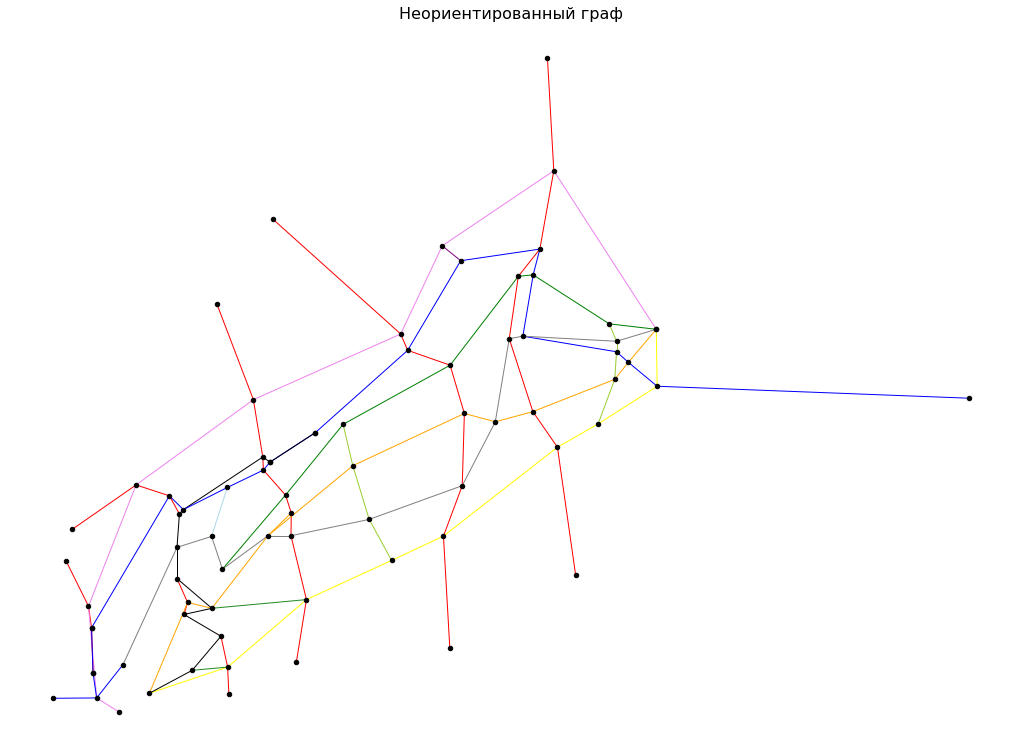

In [155]:
plt.figure(figsize=(14, 10))
edge_attr   = G.edges().values()
# edge_colors [e['attr_dict']['color'] for e in edge_attr]
edge_colors = [e['attr_dict']['color'] for e in edge_attr ]

nx.draw(G, pos=node_positions,
    edge_color = edge_colors,
    node_size  = 20,
    node_color = 'black'
)
plt.title('Неориентированный граф', size=16);


In [156]:
# G.degree = {id: degree}
odd_nodes = [node for node, degree in G.degree() if degree % 2]

f'Всего {len(G.nodes())} узлов, из них {len(odd_nodes)} с нечётной степенью'

'Всего 77 узлов, из них 36 с нечётной степенью'

Вычислим "минимальное" подмножество ребер, которые необходимо дублировать, чтобы восстановить граф.
1. Найти все возможные парные комбинации узлов нечетной степени.
2. Найти кратчайший путь между каждой парой узлов
3. Создать *полный граф*, который соединяет каждую пару узлов кратчайшим путём
4. Соеденить узлы, чтобы получить минимальное подмножество ребер главного графа, которые необходимо дублировать, чтобы найти *Эйлеров путь*

In [157]:
odd_node_pairs = list(itertools.combinations(odd_nodes, 2))

In [158]:
# 'weights = (ida', 'idb'): 17
weights = {}
for pair in odd_node_pairs:
    weights[pair] = nx.dijkstra_path_length(
                    G, pair[0], pair[1],
                    weight='distance')

In [159]:
complete_G = nx.Graph()
# переворот веса, потому что алгоритмом ищет максимальный веса, а нам нужны минимальные веса
for pair, w in weights.items():
        complete_G.add_edge(
                      pair[0], pair[1],
                      distance = w,
                      weight= -w)
        
f"Всего узлов {complete_G.number_of_nodes()}, рёбер {complete_G.number_of_edges()}"

'Всего узлов 36, рёбер 630'

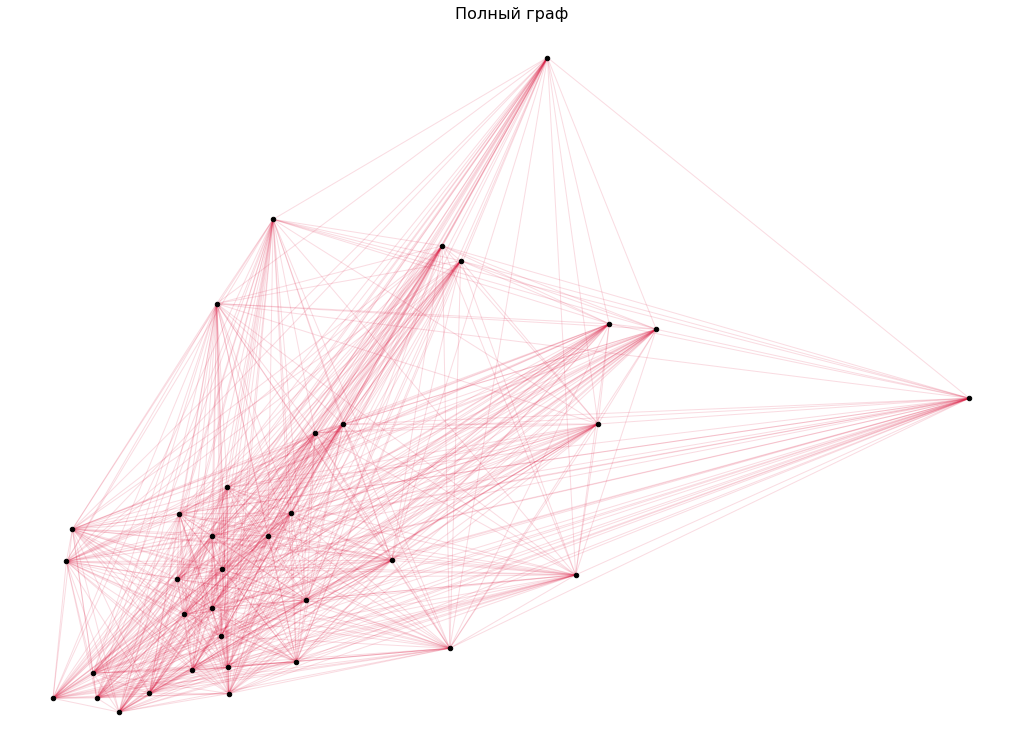

In [160]:
plt.figure(figsize=(14, 10))
nx.draw(complete_G, node_positions, alpha=0.15, edge_color = 'crimson',  node_size=1)
nx.draw_networkx_nodes(complete_G, node_positions, node_size=20, node_color='black')
plt.title('Полный граф', size=16);

In [161]:
pairs_min_weight = nx.algorithms.max_weight_matching(complete_G, maxcardinality=True)

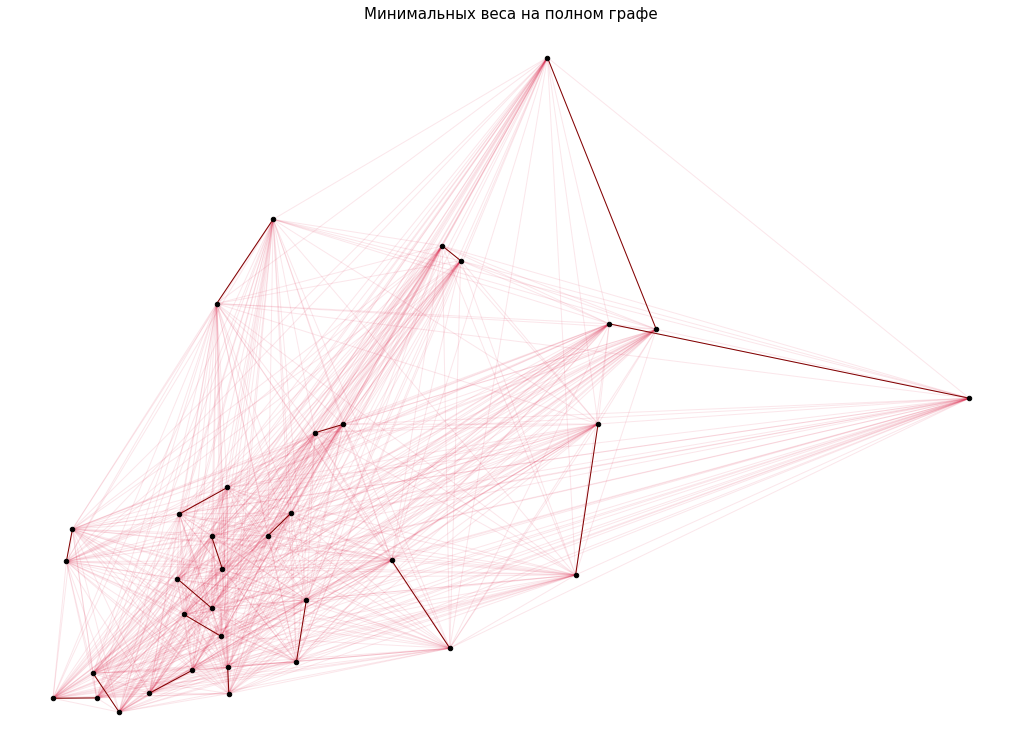

In [162]:
plt.figure(figsize=(14, 10))
nx.draw(complete_G, node_positions, alpha=0.1, edge_color = 'crimson',  node_size=1)

dg = nx.Graph(list(pairs_min_weight))
nx.draw(dg, node_positions, node_size  = 20, edge_color = 'maroon', node_color = 'black')

plt.title("Минимальных веса на полном графе", size=15);

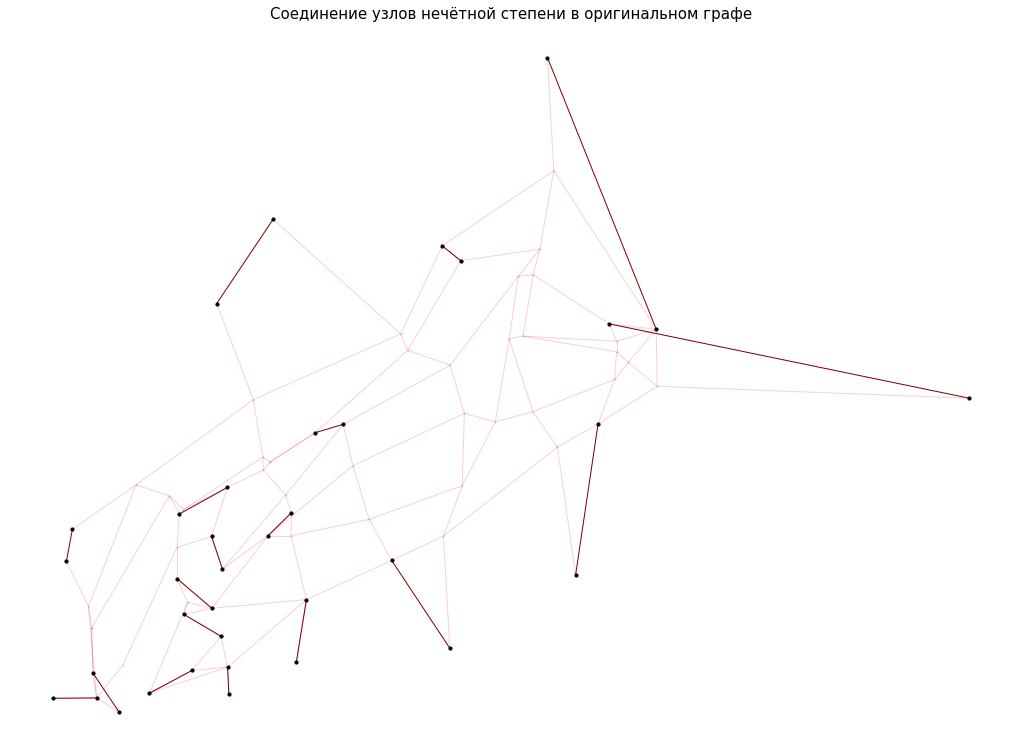

In [163]:
plt.figure(figsize=(14, 10))
nx.draw(G, node_positions, alpha=0.2, edge_color='crimson',  node_size=1)

dg = nx.Graph(list(pairs_min_weight))
nx.draw(dg, node_positions, node_size=10, edge_color='maroon', node_color='black')

plt.title("Соединение узлов нечётной степени в оригинальном графе", size=15);

In [164]:
augment_G = nx.MultiGraph(G.copy())

for pair in pairs_min_weight:
    augment_G.add_edge(
        pair[0], pair[1],
        attr_dict={ 'distance': nx.dijkstra_path_length(G, pair[0], pair[1]),'trail': 'augmented'})

In [165]:
f"Было добавлено {len(augment_G.edges()) - len(G.edges())} рёбер"

'Было добавлено 18 рёбер'

## Проверка степеней узлов

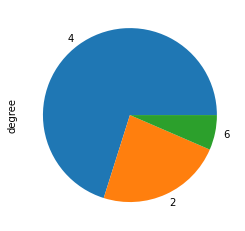

In [166]:
pd.value_counts(pd.DataFrame(augment_G.degree(), columns=['id','degree'])['degree']).plot.pie();

# Нахождение эйлеровой цепи

**псевдокод:**
построем "наивную" эйлерову схему дополненного графа и пустую "фактическую" схему
начнём перебор по "наивной" схеме Эйлера
для каждого ребра в наивной схеме:
1. если ребро является "реальным"(путь существует в оригинальном графе)
   <br>* добавим его к фактической схеме
2. если ребро является абстрактной связью (т.е. существует в дополненном графе, но не в исходном графе)
    <br>* поместим его на кратчайший путь между этими двумя узлами

In [167]:

def generate_euler_circuit(orig_G, augment_G, node_start=None):
    circuit = []
    # naive_circuit: [(id1 -> id2), (id2 -> id3)]
    naive_circuit = list(nx.eulerian_circuit(augment_G, source=node_start))
    for a, b in naive_circuit:
        # edge_data: {attr_dict: trail, distance, color, estimate}
        edge_data = augment_G.get_edge_data(a, b)[0]
        
        # ребро в исходном графе
        if edge_data['attr_dict']['trail'] != 'augmented':
            edge_attr = orig_G[a][b]
            circuit.append((a, b, edge_attr))
            
        else:
            augment_path       = nx.shortest_path(orig_G, a, b, weight='distance')
            augment_path_pairs = list(zip(augment_path[:-1], augment_path[1:]))
            
            print(
                f'Реконструкция абстрактного соеденения: {a, b}\n'
                f'Расширение с помощью пути: {" => ".join(augment_path)}\n'
                f'Расширенные путевые пары: {augment_path_pairs}\n'
            )
            # поиск кратчайшего пути между узлами
            for a_aug, b_aug in augment_path_pairs:
                edge_aug_attr = orig_G[a_aug][b_aug]
                circuit.append((a_aug, b_aug, edge_aug_attr))
                
    return circuit

In [168]:
start = 'b_end_east'
circuit = generate_euler_circuit(G, augment_G, node_start=start)

Реконструкция абстрактного соеденения: ('b_end_east', 'g_gy2')
Расширение с помощью пути: b_end_east => b_y => park_east => g_gy2
Расширенные путевые пары: [('b_end_east', 'b_y'), ('b_y', 'park_east'), ('park_east', 'g_gy2')]

Реконструкция абстрактного соеденения: ('y_gy2', 'rs_end_south')
Расширение с помощью пути: y_gy2 => y_rs => rs_end_south
Расширенные путевые пары: [('y_gy2', 'y_rs'), ('y_rs', 'rs_end_south')]

Реконструкция абстрактного соеденения: ('y_gy1', 'rc_end_south')
Расширение с помощью пути: y_gy1 => y_rc => rc_end_south
Расширенные путевые пары: [('y_gy1', 'y_rc'), ('y_rc', 'rc_end_south')]

Реконструкция абстрактного соеденения: ('g_gy1', 'b_tt_3')
Расширение с помощью пути: g_gy1 => g_rc => b_rc => b_tt_3
Расширенные путевые пары: [('g_gy1', 'g_rc'), ('g_rc', 'b_rc'), ('b_rc', 'b_tt_3')]

Реконструкция абстрактного соеденения: ('rh_end_tt_1', 'b_bw')
Расширение с помощью пути: rh_end_tt_1 => b_tt_1 => b_bw
Расширенные путевые пары: [('rh_end_tt_1', 'b_tt_1'), ('b_tt

In [169]:
f'В получившемся Эйлеровом пути {len(circuit)} шага'

'В получившемся Эйлеровом пути 154 шага'

In [170]:
dist_G  = sum(e[2]['attr_dict']['distance'] for e in G.edges(data=True))
dist_circuit = sum(e[2]['attr_dict']['distance'] for e in circuit)
print(
f"""{dist_G:.2f} - общее расстояние
{dist_circuit:.2f} - расстояние получившейся цепи
{dist_circuit-dist_G:.2f} - расстояние отката ({(dist_circuit-dist_G)/dist_G:.1%}))""")
print(
f"""\n\n{len(G.edges())} - рёбер в графе
{len(circuit)} - рёбер в получившеся цепи
{len(circuit)-len(G.edges())} - рёбер пройденно дважды""")

25.76 - общее расстояние
34.15 - расстояние получившейся цепи
8.39 - расстояние отката (32.6%))


123 - рёбер в графе
154 - рёбер в получившеся цепи
31 - рёбер пройденно дважды


**Псевдокод:**
<br>Cоздать пустой словарь ребер

Для каждого ребра эйлеровой цепи 
1. если ребро еще не находится в словаре ребер,    
>добавьте ребро в качестве ключа, используя visits=1 и sequence=str(номер шага) в качестве данных  
2. если ребро уже находится в словаре ребер,
> увеличить количество посещений на 1 и добавьте str(номер шага) к sequence

In [171]:
def generate_backtraking_edges(euler_circuit):
    e_deduped = {}
    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]]) 
        if edge in e_deduped:
            
            e_deduped[edge][2]['sequence'] += f', {str(i)}'
            e_deduped[edge][2]['visits']   += 1
        else:
            e_deduped[edge] = e
            
            e_deduped[edge][2]['sequence'] = str(i)
            e_deduped[edge][2]['visits']   = 1
    
    return list(e_deduped.values())


In [172]:
inspected_G = nx.Graph(generate_backtraking_edges(circuit))

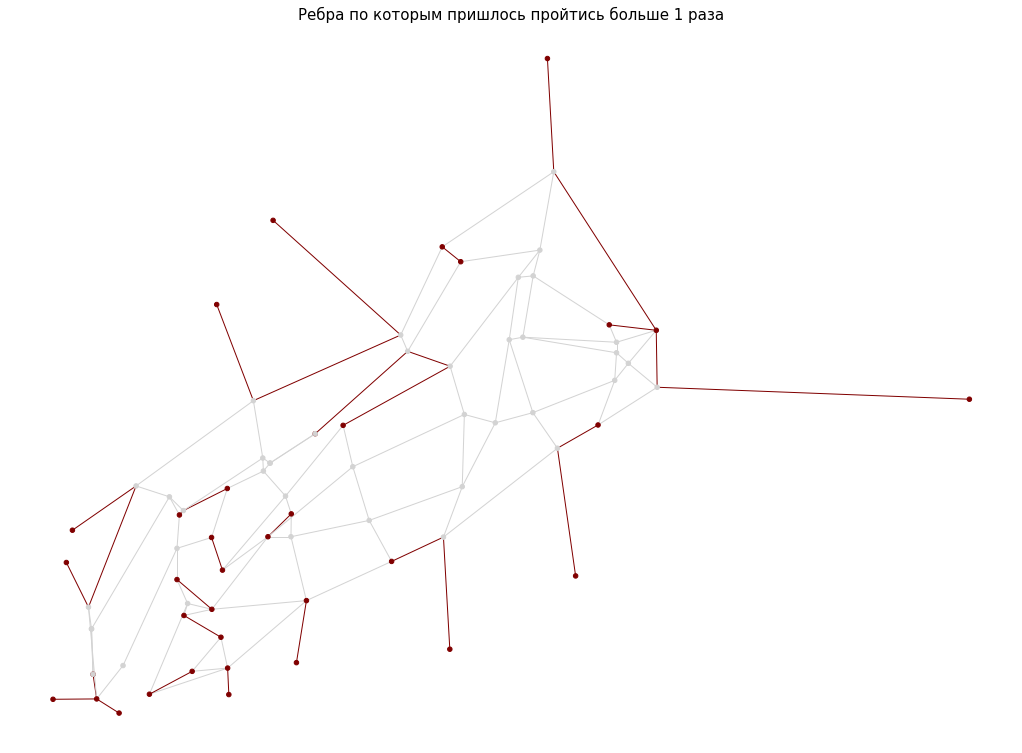

In [173]:
plt.figure(figsize=(14, 10))
visit_colors = {1: 'lightgray', 2: 'maroon'}

edge_colors = [visit_colors[e[2]['visits']] for e in inspected_G.edges(data=True)]
node_colors = ['maroon' if node in odd_nodes else 'lightgray' for node in inspected_G.nodes()]

nx.draw(inspected_G, pos=node_positions,
    node_size=20, node_color=node_colors,
    edge_color=edge_colors
)
plt.title('Ребра по которым пришлось пройтись больше 1 раза', size=15);

# Визуализация
<img src='anime.gif'>

In [174]:
def generate_still(euler_circuit):
    visit_colors = {1: 'black', 2: 'orange'}
    edge_counter      = {}
    frame_edge_colors = []
    for i, e in enumerate(euler_circuit, start=1):
        edge = frozenset([e[0], e[1]])
        if edge in edge_counter:
            edge_counter[edge] += 1
        else:
            edge_counter[edge]  = 1
        nx.draw_networkx(
            inspected_G,pos=node_positions,
            node_size= 6,
            node_color= 'gray',
            alpha= 0.05,
            with_labels = False
        )
        # получить ребра, пройденные всеми итерациями < i
        _circuit = copy.deepcopy(euler_circuit[0:i])
        for n in range(len(_circuit)):        
            _edge = frozenset([_circuit[n][0], _circuit[n][1]])
            _circuit[n][2]['_visits'] = edge_counter[_edge]
        _g = nx.Graph(_circuit)
        _g_edge_colors = [visit_colors[e[2]['_visits']] for e in _g.edges(data=True)]
        
        nx.draw_networkx_nodes(
            _g,pos= node_positions,
            alpha= 0.4,
            node_size= 6,
            node_color= 'lightgray',
            with_labels = False)
        
        nx.draw_networkx_edges(
            _g,pos= node_positions,
            edge_color= _g_edge_colors,
            alpha= 0.8, with_labels = False)
        
        plt.axis('off')
        plt.savefig(f'stills/{i}.png', dpi=120, bbox_inches='tight')
        print('Записана картинка',i)
        plt.close()
    print(f'Готово, создано {i} фото.')

In [175]:
generate_still(circuit)

Готово, создано 154 фото.


In [176]:
def render_animation(stills_dir, anim_filename, fps=6):
    img_names_sorted = [f"{stills_dir}{i}.png" for i in range(1, 154)]
    with imageio.get_writer(anim_filename, mode='I', fps=fps) as w:
        for f in img_names_sorted:
            img = imageio.imread(f)
            w.append_data(img)

In [177]:
import glob
import imageio
import numpy as np
import os
render_animation('stills/', 'anime.gif')

from IPython.display import Image
Image(filename='anime.gif');